# Graph Analysis and Visualization Tools in Cytoscape/Notebook Ecosystem

![title](https://www.timlrx.com/_next/image?url=%2Fstatic%2Fimg%2Fgraph_libraries.png&w=3840&q=75)

[(Image from this page)](https://www.timlrx.com/blog/benchmark-of-popular-graph-network-packages-v2)

### Lab Meeting (1/26/2022)
Keiichiro Ono (Ideker Lab Software Team)

kono@ucsd.edu

## TL;DR (Summary and Colclusion)
    - There is no "one-size-fits-all" solution for biological network analysis and visualization
        - Combination of multiple tools/libraries is necessary
    - You need to use multiple tools for data wrangling and conversion
    - Use efficient library optimized for multi-core environment
    - Interacvtive style editing in notebook environment is desirable, but not available (yet)
    - Because of these small, but annoying barriers/problems, there is room for improvement
        - New toolkits for the Cytoscape Ecosystem, including high-level 

## Background
### Software team is still in the middle of the transition to the web-based ecosystem for biological network analysis and visualization.
### This presentation is a survay/tutorial of extinting tools and libraries abailable now and discuss missing pieces to build easy-to-use pipeline for network visualization.

    - We need ot support for both:
        - Casual users
        - Advanced users (bioinformaticians)

## Topics Covered
### This Python ecosystem only
#### R/Julia/Rust/JS has different toolchains (and maybe covered in future tutorial sessions)
    - Search & import data directly from NDEx
    - Convert CX to popular libraries' data formats
    - Analyze network with some popular libraries
    - Visualization
        - Static (publication-ready) images
        - Interactive cells

----

## Hands-on Tutorial

- Install [Docker Desktop](https://www.docker.com/products/docker-desktop)
- Clone / download this repository
- Run the following command to start notebook

#### Note: Cytoscape Desktop will not be used in this example


In [1]:
!python3 --version

Python 3.9.5


## Dependencies

This Docker image contains a lot of libraries. You can install these directly into your laptop, but I recommend to use the container for now (some of the libraries are bit tricky to install)

In [3]:
from graph_tool.all import *
import json
import ndex2

import ipycytoscape
import ipywidgets as widgets
import networkx as nx

import ipywidgets as widgets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Data Import from NDEx

## NDEx2 Python client

You can use _ndex2_ Python client library for directly fetching network data from [NDEx](https://www.ndexbio.org)

### Search NDEx database
(You can skip this step if you already have network data)

- If you want to batch-process networks in NDEx server, you can use this client to search & fetch data in CX
- There are amy ways to get networks you need.  Please referer the documentation for more details

#### Potential new tool idea
 - Higher-level utility funciton for search & filter the search results? 

In [47]:
import json
import ndex2

# Create NDEx2 python client
nc2 = ndex2.client.Ndex2()

# Search COVID-related networks using free-keyword
response1 = nc2.search_networks('covid*')
print('Found: ' + str(response1['numFound']) + ' entries')

Found: 75 entries


In [48]:
# Filter & sort the result (networks with more than 10k edges)

MIN_EGDE_COUNT = 10000

networks = response1['networks']
large_networks = filter(lambda net: net['edgeCount'] > MIN_EGDE_COUNT, networks)
lg_sorted = sorted(large_networks, key=lambda net: int(net['edgeCount']))

for net in lg_sorted:
    print(net['name'] + ': (node, edge) = (' + str(net['nodeCount']) + ', ' + str(net['edgeCount']) + ') ' + net['externalId'])

The COVID-19 patient biopsy (basal) network.: (node, edge) = (4237, 15815) 5ab94147-f0f7-11ea-99da-0ac135e8bacf
BioGRID Curation Projects: Coronavirus - Interactions and Post-translational Modifications: (node, edge) = (4983, 16762) af5ba599-680b-11eb-9e72-0ac135e8bacf
BIOGRID-PROJECT-covid19_coronavirus_project-INTERACTIONS-4.4.198: (node, edge) = (5107, 22372) edf2cd78-cad1-11eb-9a85-0ac135e8bacf
The basal gene network in the involvement of respiratory viruses infection including SARS-CoV-2.: (node, edge) = (15258, 127126) 116f99ca-f0fd-11ea-99da-0ac135e8bacf
covid19: (node, edge) = (52161, 504407) a8c0decc-6bbb-11ea-bfdc-0ac135e8bacf


## Fetch data from NDEx


In [49]:
# Try the first one

# COVID_PPI_UUID = '6398ce70-cee6-11ea-aaef-0ac135e8bacf'
COVID_PPI_UUID = lg_sorted[0]['externalId']

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
response1 = nc2.get_network_as_cx_stream(COVID_PPI_UUID)

# Convert downloaded network to NiceCXNetwork object
cov_cx = ndex2.create_nice_cx_from_raw_cx(json.loads(response1.content))

# Display information about network and output 1st 100 characters of CX
cov_cx.print_summary()

Name: The COVID-19 patient biopsy (basal) network.
Nodes: 4237
Edges: 15815
Node Attributes: 0
Edge Attributes: 94890



## Convert CX to other data formats

- NetworkX
- pandas (Data Frame)
- dot (Graphviz)

In [50]:
# Create Networkx network
nx_graph = cov_cx.to_networkx(mode='default')

# To DOT (Graphviz format)
DOT1 = 'temp-prepared.dot'
nx.nx_agraph.write_dot(nx_graph, DOT1)

## Graph Analysys and visualization with _**graph-tool**_

### Why graph-tool?
- C++ library optimized for multi-core machines
- **MUCH** faster than NetworkX
    - It is simply wast of energy (computing resource) if you use NetworkX in your production code that processes a lot of data (see below)

![comparison](https://github.com/timlrx/graph-benchmarks/blob/master/runtime_results.png?raw=true)
    


In [51]:
# Create a graph-tool network object　from DOT
gt_1 = load_graph(DOT1)

In [54]:
state = minimize_blockmodel_dl(gt_1)
pal1 = sns.color_palette()

import numpy as np
list1 = state.get_blocks().get_array()
np.unique(list1)

PropertyArray([ 140,  219,  400,  488,  650,  698,  707,  770,  802,  835,
                981, 1043, 1258, 1268, 1442, 1640, 1658, 1757, 1895, 2113,
               2235, 2385, 2417, 2435, 2478, 2549, 2551, 2671, 2786, 2899,
               2928, 2945, 2961, 2985, 3132, 3160, 3485, 3588, 3726, 3922,
               4121, 4216], dtype=int32)

In [63]:
def get_color(idx):
    rgb = pal1[idx%10]
    return [rgb[0], rgb[1], rgb[2], 1]

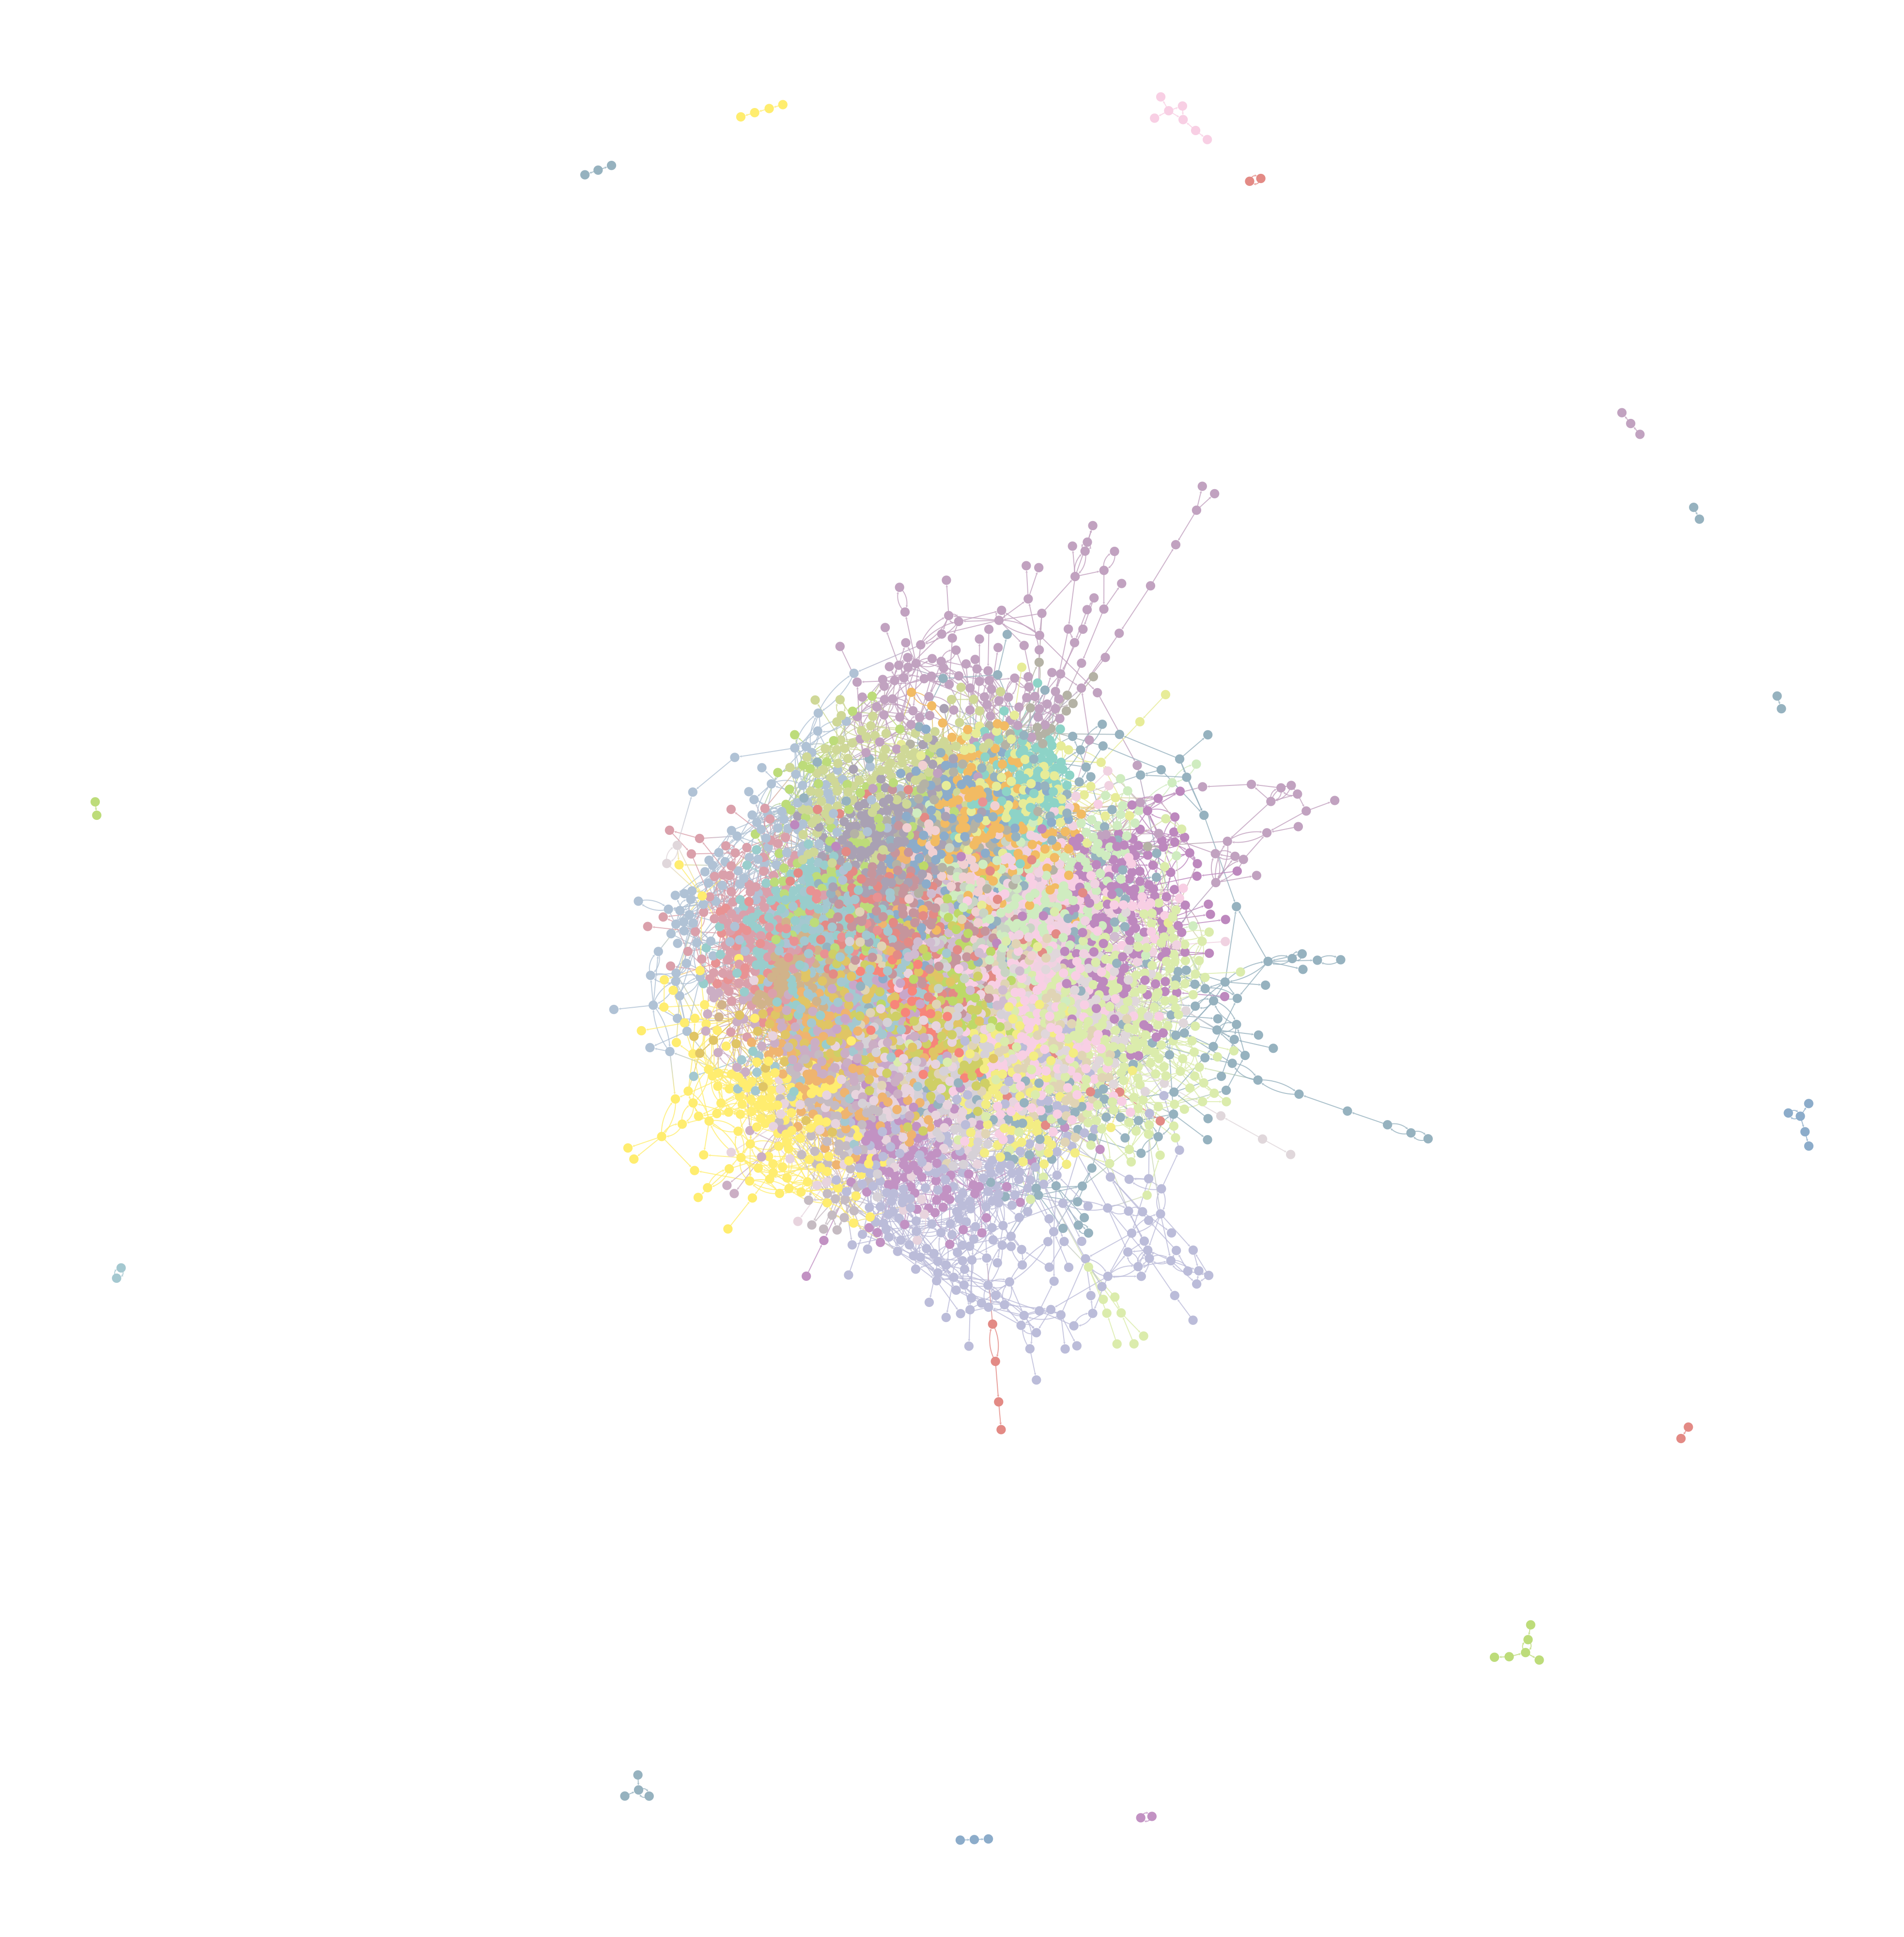

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff82b93be0, at 0x7eff82d46460>

In [56]:
# apply layout using membership info
blocks = state.get_blocks()
# pos1 = sfdp_layout(gt_1, groups=blocks)
# state.draw(output_size=(3000, 3000), vertex_text=gt_1.vertex_properties.get('name'), edge_pen_width=1)
state.draw(output_size=(2000, 2000), edge_pen_width=1)

In [28]:
# Visualize it
import matplotlib
graph_draw(gt_1, pos1, output_size=(1000, 1000), vertex_color=[10,1,1,0],
           vertex_size=2, edge_pen_width=0.2,
           vcmap=matplotlib.cm.gist_heat_r, output="covid2.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc239d96280, at 0x7fc2388e83a0>

In [54]:
from IPython import display
# display.Image("./covid2.png")

### Interactrive Visualization

In [3]:
viz1 = ipycytoscape.CytoscapeWidget()
viz1.graph.add_graph_from_networkx(nxg1)
viz1.set_layout(name='preset')
display(viz1)

CytoscapeWidget(cytoscape_layout={'name': 'preset'}, cytoscape_style=[{'selector': 'node', 'css': {'background…

### Problem:
- Visual Style is missing
- Interactivity
  - Editing style

# NetworkX
## Pros
    - Easy to install
    - Well documented
    - A lot of utility functions
        - Data conversion
        - I/O supports most of the existing graph formats

## Cons
### - Extremely slow

In [4]:
widgets.IntSlider()

IntSlider(value=0)

In [3]:
g = Graph()

G = nx.complete_graph(5)
undirected = ipycytoscape.CytoscapeWidget()
undirected.graph.add_graph_from_networkx(G)
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

## Data-Driven styling

### Limitation
Currently, there is no high-level, interactive toolkit to generate data-driven styles

- What kind of features do we need?




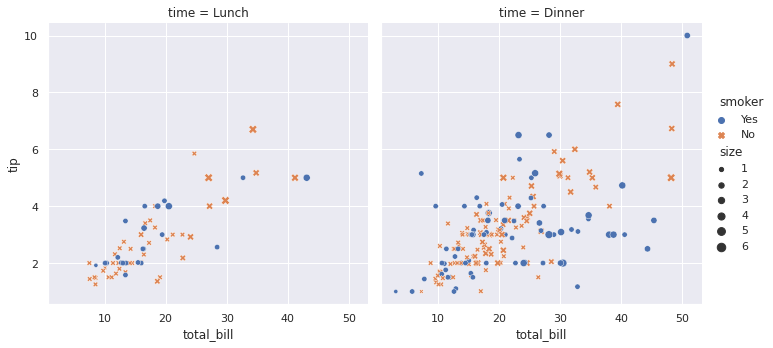

In [3]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

In [5]:
pal1 = sns.color_palette()

In [7]:
pal2 = sns.color_palette("magma", as_cmap=True)

In [17]:
len(pal1)

10

# Summary

## Recommendations for task types

### Data Format Conversion / Data Wrangling
    - NetworkX
    - Pandas
    
### 